Check where the MHW offset has been applied vs. not. E.g. DH_z is MHW or not? 

In [1]:
import os
import sys
import time
import shutil
import pandas as pd
import numpy as np
import arcpy
import CoastalVarExtractor.functions_warcpy as fwa
import CoastalVarExtractor.functions as fun

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from CoastalVarExtractor.setvars import *

site: Fisherman
year: 2014
setvars.py initialized variables.


In [2]:
# %% Open pickled dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, transPts_null+'.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'.pkl'))

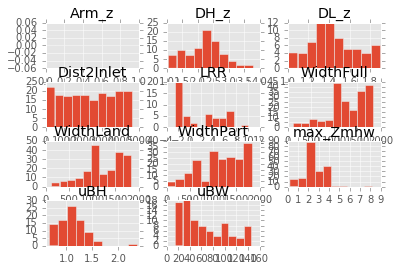

In [5]:
# Histograms for each transect variable
hist_cols = ['Arm_z', 'DH_z', 'DL_z', 'Dist2Inlet', 'LRR', 'WidthFull', 'WidthLand', 
             'WidthPart', 'max_Zmhw', 'uBH', 'uBW']
trans_df.loc[:,hist_cols].hist()
plt.show()
plt.close('all')

In [9]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]
# pts_set.WidthLand.loc[150] / len(pts_set)

Transect ID (1-194): 190


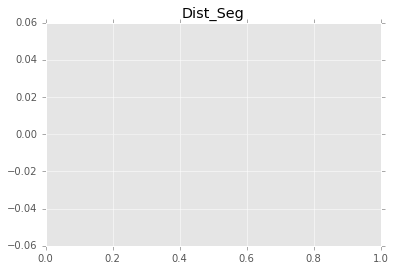

,dist_seg,hypot
34892,NaN,NaN
34893,NaN,NaN
34894,NaN,NaN
34895,NaN,NaN
34896,NaN,NaN
34897,NaN,NaN
34898,NaN,NaN
34899,NaN,NaN
34900,NaN,NaN
34901,NaN,NaN


In [10]:
hist_cols = ['Dist_Seg']
pts_set.loc[:,hist_cols].hist()
plt.show()
plt.close('all')
# pts_set.head()

dist_seg = pd.DataFrame({'hypot': 
                         np.hypot(pts_set.seg_x - pts_set.SL_x, pts_set.seg_y - pts_set.SL_y),
                         'dist_seg': pts_set.loc[:,'Dist_Seg']})
dist_seg
# Dist_Seg is the calculation that results from hypotenuse of seg_x and SL_x...
# ...so one of these is wrong? 

Transect ID (1-194): 114


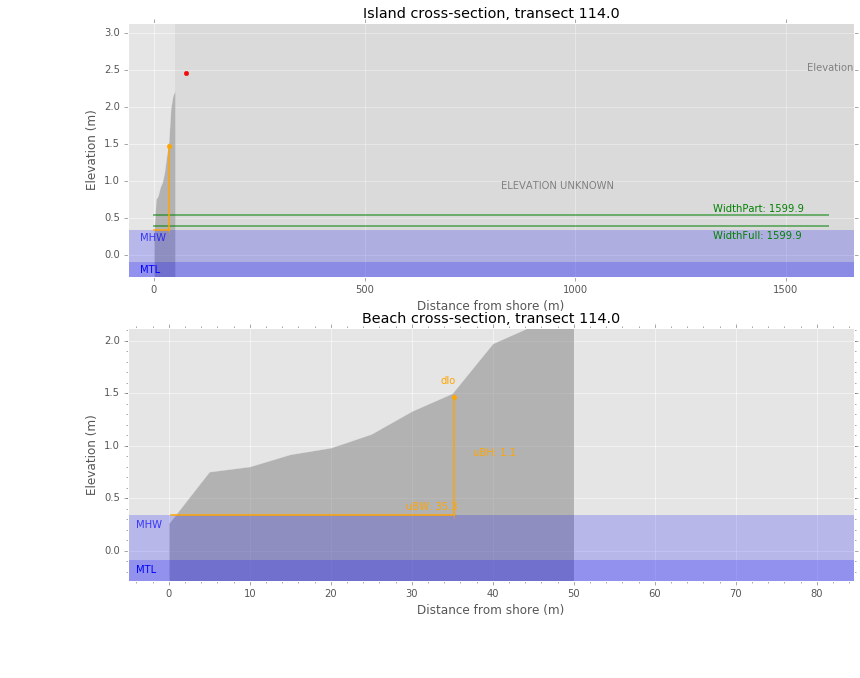

In [5]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]
# pts_set.WidthLand.loc[150] / len(pts_set)
# plot
fig = plt.figure(figsize=(13,10)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(211)
fun.plot_island_profile(ax, pts_set, MHW, MTL)
ax = fig.add_subplot(212)
fun.plot_beach_profile(ax, pts_set, MHW, MTL, maxDH)
# display
plt.show()
plt.close('all')

In [39]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Get the transect-averaged values
tran = pts_set.iloc[0]


# check for presence of values
flds = ['Dist_Seg', 'ptZmhw', 'WidthPart', 'WidthFull']
for fld in flds: 
    if pts_set[fld].isnull().sum():
        print('{}/{} values are missing in column {}.'.format(
            pts_set[fld].isnull().sum(), len(pts_set), fld))

pts_set['Dist_Seg'].max()

Transect ID (1-194): 50


560.00000000148225

In [131]:
def get_beachplot_values(pts_set):
    tran = pts_set.iloc[0]

    # Get maximum Z values
    idmaxz = pts_set['ptZmhw'].idxmax()
    maxz = pts_set['ptZmhw'].loc[idmaxz]
    mz_xy = pts_set[['seg_x', 'seg_y']].loc[idmaxz]
    mz_dist = np.hypot(mz_xy.seg_x - tran.SL_x, mz_xy.seg_y- tran.SL_y)    

    # Get beach end and beach top
    if not np.isnan(tran.DistDH):
        bend = tran.DistDH
        btop = tran.DH_z
    elif not np.isnan(mz_dist):
        bend = mz_dist
        btop = maxz
    else: 
        bend = 200
        btop = 4
    
    # Return
    return(tran, idmaxz, maxz, mz_xy, mz_dist, bend, btop)

def plot_island_profile(ax, pts_set, MHW, MTL):
    # Get prep values
    tran, idmaxz, maxz, mz_xy, mz_dist, bend, btop = get_beachplot_values(pts_set)
    
    # Axes limits
    xllim = -tran.WidthFull*0.038
    xulim = tran.WidthFull + tran.WidthFull*0.038
    yllim = MTL-0.2
    yulim = maxz+1.25

    # Subplot Labels
    ax.set_xlabel('Distance from shore (m)', fontsize = 12)
    ax.set_ylabel('Elevation (m)', fontsize = 12)
    ax.set_title('Island cross-section, transect {}'.format(trans_in))

    # Plot line
    # ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, color='gray', linestyle='-', linewidth = 1)
    ax.fill_between(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, y2=yllim, facecolor='grey', alpha=0.5)
    plt.annotate('Elevation', xy=(tran.WidthFull-50, float(pts_set['ptZmhw'].tail(1))+0.6), color='gray')
    ax.axvspan(xmin=pts_set['Dist_Seg'].max(), xmax=xulim, color='grey', alpha=0.1)
    plt.annotate('ELEVATION UNKNOWN', xy=(np.mean([pts_set['Dist_Seg'].max(), tran.WidthFull]), np.mean([maxz, MTL])), color='gray')
    
    # #Island widths
    plt.plot([0, tran.WidthPart],[MHW+0.2, MHW+0.2], color='green', linestyle='-', linewidth = 2, alpha=0.5)
    plt.annotate('WidthPart: {:.1f}'.format(tran.WidthPart), xy=(tran.WidthFull*0.83, MHW+0.24), color='green')
    plt.plot([0, tran.WidthFull],[MHW+0.06, MHW+0.06], color='green', linestyle='-', linewidth = 2, alpha=0.5)
    plt.annotate('WidthFull: {:.1f}'.format(tran.WidthFull), xy=(tran.WidthFull*0.83, MHW-0.12), color='green')

    # #Beach points
    plt.scatter(tran.DistDL, tran.DL_z, color='orange')
    plt.scatter(tran.DistDH, tran.DH_z, color='red')
    plt.scatter(tran.DistArm, tran.Arm_z, color='black')

    # #Upper beach width and height
    plt.plot([MHW, tran.uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
    plt.plot([tran.uBW, tran.uBW],[MHW, MHW + tran.uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')

    # #ax.axis('scaled')
    ax.set_xlim([xllim, xulim])
    ax.set_ylim([yllim, yulim])
    # ax.axhline(y=MTL, ls='dotted', color='black')
    ax.axhspan(ymin=-0.5, ymax=MTL, xmin=xllim, xmax=xulim, alpha=0.2, color='blue')
    plt.annotate('MTL', xy=(-tran.WidthFull*0.02, MTL-0.15), color='blue')
    # ax.axhline(y=MHW, ls='dotted', color='black')
    ax.axhspan(ymin=-0.5, ymax=MHW, xmin=xllim, xmax=xulim, alpha=0.2, color='blue')
    plt.annotate('MHW', xy=(-tran.WidthFull*0.02, MHW-0.15), color='blue', alpha=0.7)
    

Transect ID (1-194): 130


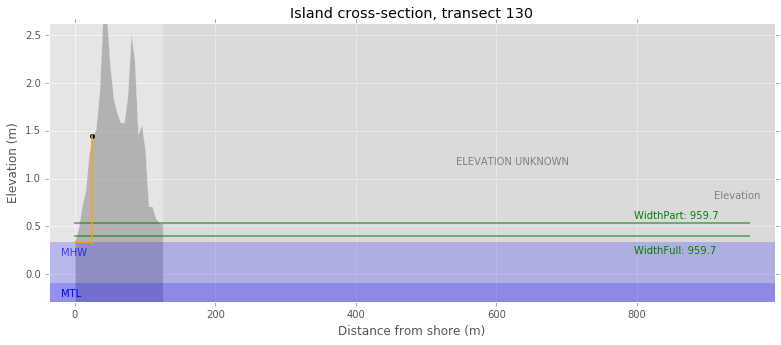

In [116]:
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

    
# Full cross-section
fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)
plot_island_profile(ax, pts_set, MHW, MTL)
plt.show()
plt.close('all')

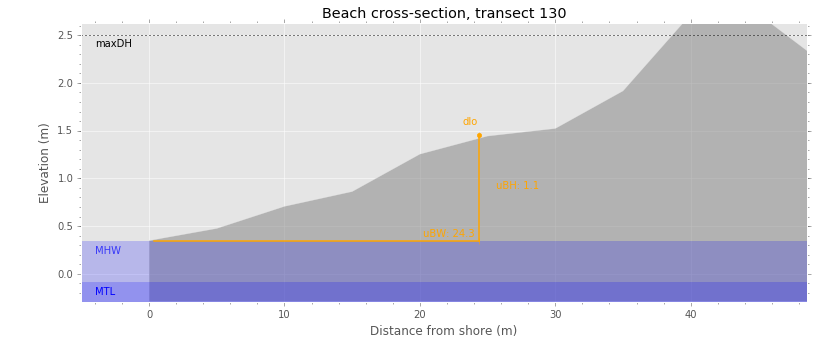

In [117]:
def plot_beach_profile(ax, pts_set, MHW, MTL, maxDH):
    # Get prep values
    tran, idmaxz, maxz, mz_xy, mz_dist, bend, btop = get_beachplot_values(pts_set)
    
    # Axes limits
    xllim = -5
    xulim = bend+bend*0.11
    yllim = MTL-0.2
    yulim = maxz+0.25
    
    # Subplot Labels
    ax.set_xlabel('Distance from shore (m)', fontsize = 12)
    ax.set_ylabel('Elevation (m)', fontsize = 12)
    ax.set_title('Beach cross-section, transect {}'.format(trans_in))

    # Plot line
    # ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, color='gray', linestyle='-', linewidth = 1, marker='.')
    ax.fill_between(pts_set['Dist_Seg'], pts_set['ptZmhw']+MHW, y2=yllim, facecolor='grey', alpha=0.5)
    plt.annotate('Elevation', xy=(bend+bend*0.025, btop), color='gray')

    # Beach points
    plt.scatter(tran.DistDL, tran.DL_z, color='orange')
    plt.annotate('dlo', xy=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.08), color='orange')
    plt.scatter(tran.DistDH, tran.DH_z, color='red')
    plt.annotate('dhi', xy=(tran.DistDH-bend*0.02, tran.DH_z+btop*0.08), color='red')
    plt.scatter(tran.DistArm, tran.Arm_z, color='black')
    plt.annotate('armor', xy=(tran.DistArm-20, tran.Arm_z+0.5), color='black')

    # Upper beach width and height
    uBW = tran.uBW
    uBH = tran.uBH
    plt.plot([MHW, uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
    plt.annotate('uBW: {:.1f}'.format(uBW), xy=(uBW*0.83, MHW+0.05), color='orange')
    plt.plot([uBW, uBW],[MHW, MHW + uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')
    plt.annotate('uBH: {:.1f}'.format(uBH), xy=(uBW+bend*0.03, MHW + uBH*0.5), color='orange')

    # Axis/context
    ax.set_xlim([-5, bend+bend*0.11])
    ax.set_ylim([yllim, yulim])
    ax.minorticks_on()
    ax.axhspan(ymin=-0.5, ymax=MTL, xmin=xllim, xmax=xulim, alpha=0.2, color='blue')
    plt.annotate('MTL', xy=(-4, MTL-0.12), color='blue')
    ax.axhspan(ymin=-0.5, ymax=MHW, xmin=xllim, xmax=xulim, alpha=0.2, color='blue')
    plt.annotate('MHW', xy=(-4, MHW-0.12), color='blue', alpha=0.7)
    ax.axhline(y=maxDH, ls='dotted', color='black')
    plt.annotate('maxDH', xy=(5, maxDH), xytext=(-4, maxDH-0.12), color='black')
    
# Beach detail
fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)
plot_beach_profile(ax, pts_set, MHW, MTL, maxDH)
plt.show()
plt.close('all')

In [94]:
pts_set.loc[:,['sort_ID','DH_x', 'DH_y', 'DH_zmhw', 'DistDH']].head()

,sort_ID,DH_x,DH_y,DH_zmhw,DistDH
14551,74,414021.5733,4.104827e+06,0.730247,110.701411
14552,74,414021.5733,4.104827e+06,0.730247,110.701411
14553,74,414021.5733,4.104827e+06,0.730247,110.701411
14554,74,414021.5733,4.104827e+06,0.730247,110.701411
14555,74,414021.5733,4.104827e+06,0.730247,110.701411


Transect ID (1-194): 90


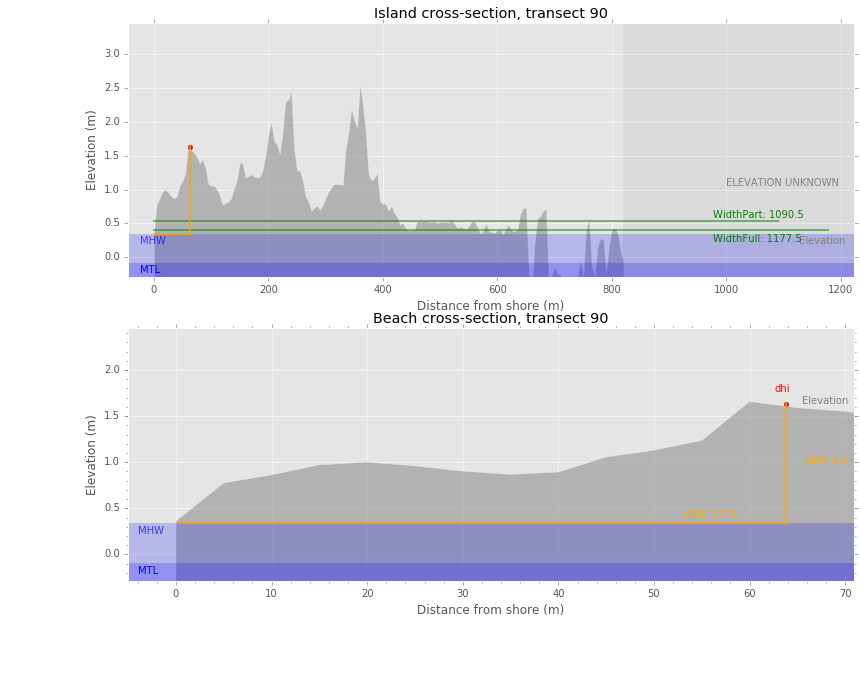

In [132]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]
# pts_set.WidthLand.loc[150] / len(pts_set)
# plot
fig = plt.figure(figsize=(13,10)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(211)
plot_island_profile(ax, pts_set, MHW, MTL)
ax = fig.add_subplot(212)
plot_beach_profile(ax, pts_set, MHW, MTL, maxDH)
# display
plt.show()
plt.close('all')